In [1]:
import json
import math
import multiprocessing

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
pool = multiprocessing.Pool()
pool._processes

40

In [3]:
MACHINE_ASTROPHYSICS = "Astrophysics"
MACHINE_RAPISCAN = "Rapiscan"
MACHINE_SMITH = "Smith"

ASTROPHYSICS_LAYOUT_HEIGHT_BOUNDARY = 1000

RAPISCAN_LAYOUT_Y_BOUNDARY = 40
RAPISCAN_LAYOUT_HEIGHT_BOUNDARY = 980

SMITH_LAYOUT_HEIGHT_BOUNDARY = 920

CONTOUR_AREA_BOUNDARY = 4000000

In [4]:
class DangerDataset(Dataset):
    def __init__(self, data_path_list: list, label_list: list, img_size: tuple):
        self.data_path_list = data_path_list
        self.label_list = label_list
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, idx: int) -> tuple:
        data_path = self.data_path_list[idx]
        machine = data_path.split("/")[2]
        img_data = cv2.imread(data_path)
        
        img_data = self._cut_layout(img_data, machine)
        
        if machine == MACHINE_ASTROPHYSICS:
            boundary_box = self._get_boundary_box(img_data)
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            pil_img_data = Image.fromarray(img_data)
            pil_img_data = pil_img_data.crop(boundary_box)
        else:
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            pil_img_data = Image.fromarray(img_data)

        img_data = self.transform(pil_img_data)
        label = self.label_list[idx]
        
        pil_img_data.close()
        
        return img_data, label

    def __len__(self) -> int:
        return len(self.data_path_list)
    
    """
    https://stackoverflow.com/questions/37803903/opencv-and-python-for-auto-cropping
    """
    def _get_boundary_box(self, img_data):
        img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.blur(img_gray, (15,15))

        ret, thresh = cv2.threshold(img_gray, math.floor(np.average(img_gray)), 255, cv2.THRESH_BINARY_INV)
        dilated = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
        contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        new_contours = []

        for contour in contours:
            if cv2.contourArea(contour) < CONTOUR_AREA_BOUNDARY:
                new_contours.append(contour)

        boundary_box = [-1, -1, -1, -1]

        for contour in new_contours:
            x, y, w, h = cv2.boundingRect(contour)

            if boundary_box[0] < 0:
                boundary_box = [x, y, w, h]
            else:
                if x < boundary_box[0]:
                    boundary_box[0] = x
                if y < boundary_box[1]:
                    boundary_box[1] = y
                if x + w > boundary_box[2]:
                    boundary_box[2] = x + w
                if y + h > boundary_box[3]:
                    boundary_box[3] = y + h
        
        return boundary_box
    
    def _cut_layout(self, img_data, machine):
        if machine == MACHINE_ASTROPHYSICS:
            return img_data[:ASTROPHYSICS_LAYOUT_HEIGHT_BOUNDARY, :]
        elif machine == MACHINE_RAPISCAN:
            return img_data[RAPISCAN_LAYOUT_Y_BOUNDARY:RAPISCAN_LAYOUT_HEIGHT_BOUNDARY, :]
        elif machine == MACHINE_SMITH:
            return img_data[:SMITH_LAYOUT_HEIGHT_BOUNDARY, :]

In [5]:
# image_type: 'Multiple_Categories', 'Multiple_Other', 'Single_Default', 'Single_Other'
def get_path(annotation_path: str, image_type: str="", duplicate_check: bool=True) -> tuple:
    entire_data = None
    image_path_list = list()
    label_list = list()
    image_metadata_list = list()
    category_dict = dict()
    
    avg_width = 0
    avg_height = 0
    img_num = 0
    
    with open(annotation_path) as json_file:
        entire_data = json.load(json_file)
    
    image_data_list = entire_data['images']
    category_data_list = entire_data['categories']
    annotation_data_list = entire_data['annotations']
    
    # 이미지 경로 파싱 && label 파싱 && 메타데이터 파싱 && width 와 hegiht 파싱
    for image_data_dict in image_data_list:
        split_path_list = image_data_dict['path'].split('/')
        curr_image_type = split_path_list[-2]
        
        # 만약 해당 image_type 이 아니면 다음 index 로
        if image_type != "" and curr_image_type != image_type:
            continue
            
        image_metadata = {
            'path': image_data_dict['path'],
            'image_id': image_data_dict['id'],
            'image_type': curr_image_type,
            'object_metadata_list': list()
        }
        
        image_metadata_list.append(image_metadata)
        
        avg_width += image_data_dict['width']
        avg_height += image_data_dict['height']
        img_num += 1
        
    avg_width /= img_num
    avg_height /= img_num

    # 이미지 id 로 metadata 파싱
    last_image_idx = 0
    current_annotation_idx = 0
    count_annotation_idx = 0
    length_annotation_data_list = len(annotation_data_list)
    
    for image_metadata in image_metadata_list:
        
        current_metadata_list = list()
        current_annotation_idx += count_annotation_idx
        count_annotation_idx = 0
        
        for annotation_data in annotation_data_list[current_annotation_idx:length_annotation_data_list]:
            
            if image_metadata['image_id'] == annotation_data['image_id']:
                category = category_data_list[annotation_data['category_id'] - 2]['name']  # 이거 이상함 !!!!!! -2 해야 됨 (-1이 아니라)

                object_metadata = {
                    'category': category,
                    'segmentation': annotation_data['segmentation'],
                    'area': annotation_data['area'],
                    'bbox': annotation_data['bbox'],
                    'is_crowd': annotation_data['iscrowd'],
                    'color': annotation_data['color'],
                    'metadata': annotation_data['metadata']
                }

                current_metadata_list.append(object_metadata)
                count_annotation_idx += 1
            else:
                continue
                
        image_metadata['object_metadata_list'] = current_metadata_list
        
    # image_path 및 label 추출
    # 중복 무시
    if duplicate_check == False:
        for image_metadata in image_metadata_list:
            for object_metadata in image_metadata['object_metadata_list']:
                image_path_list.append(image_metadata['path'])
                label_list.append(object_metadata['category'])
    # 중복 제거
    else:
        for image_metadata in image_metadata_list:
            category_set = set()
            
            for object_metadata in image_metadata['object_metadata_list']:
                if object_metadata['category'] in category_set:
                    continue
                else:
                    category_set.add(object_metadata['category'])
                    image_path_list.append(image_metadata['path'])
                    label_list.append(object_metadata['category'])
    
    # category 매핑 데이터 생성
    for category_data_dict in category_data_list:
        category_dict[category_data_dict['name']] = category_data_dict['id']
                    
    return image_path_list, label_list, category_dict, image_metadata_list, (avg_width, avg_height)

In [6]:
"""
https://github.com/ncullen93/torchsample/blob/master/torchsample/samplers.py#L22
"""
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [7]:
def preprocessing_data(data_path_list: list, label_list: list, category_dict: dict) -> tuple:
    preprocessed_data_path_list = list()
    preprocessed_label_list = list()
    class_vector_label_list = list()
    del_label_list = list()
    label_count_dict = {key: 0 for key in category_dict.keys()}

    # 각 class 의 데이터 갯수 셈
    for label in label_list:
        label_count_dict[label] += 1
    
    # 갯수가 2개 이하인 class 는 Stratified Sampling 을 할 수 없으므로 제외
    for label, count in label_count_dict.items():
        if count < 2:
            del_label_list.append(label)
    
    # 새로운 데이터 생성
    for path, label in list(zip(data_path_list, label_list)):
        if label not in del_label_list:
            preprocessed_data_path_list.append(path)
            preprocessed_label_list.append(label)
    
    # label 을 vector 화
    for preprocessed_label in preprocessed_label_list:
        class_vector_label_list.append(category_dict[preprocessed_label])
    
    return np.asarray(preprocessed_data_path_list), np.asarray(preprocessed_label_list), np.asarray(class_vector_label_list)

In [8]:
# load_mscoco(image_path_list, label_list, batch_size=100, size=(256, 256))
def load_danger(data_path_list: list, label_list: list, category_dict: dict, batch_size: int, img_size: tuple, num_workers: int) -> tuple:
    preprocessed_data_path_list, preprocessed_label_list, class_vector_label_list = preprocessing_data(data_path_list, label_list, category_dict)
    class_vector = torch.from_numpy(class_vector_label_list)
    sampler = StratifiedSampler(class_vector=class_vector, batch_size=batch_size)
    
    danger_data = DangerDataset(preprocessed_data_path_list, preprocessed_label_list, img_size)
    
    danger_loader = DataLoader(
        danger_data,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=False,
        num_workers=num_workers
    )
    data, label = iter(danger_loader).next()
    
    return data.numpy().reshape(batch_size, -1), np.asarray(label)

In [9]:
# image_path_list, label_list, image_metadata_list = get_path("./datasets/Annotation/Astrophysics.json", 'Multiple_Categories')
image_path_list, label_list, category_dict, image_metadata_list, avg_img_size = get_path("./datasets/Annotation/Astrophysics.json")

In [10]:
new_image_path_list = list(map(lambda image_path: "." + image_path, image_path_list))

In [29]:
data, label = load_danger(
    new_image_path_list,
    label_list,
    category_dict,
    batch_size=512,
    img_size=(256, 256),
    num_workers=10
)

## Verification

#### Original Data

In [266]:
label_count_dict = {'Aerosol': 0, 'Alcohol': 0, 'Awl': 0, 'Axe': 0, 'Bat': 813, 'Battery': 1, 'Bullet': 0, 'Firecracker': 0, 'Gun': 0, 'GunParts': 0, 'Hammer': 0, 'HandCuffs': 2218, 'HDD': 0, 'Knife': 2810, 'Laptop': 4008, 'Lighter': 3384, 'Liquid': 0, 'Match': 0, 'MetalPipe': 0, 'NailClippers': 0, 'PrtableGas': 0, 'Saw': 0, 'Scissors': 1724, 'Screwdriver': 583, 'SmartPhone': 5286, 'SolidFuel': 0, 'Spanner': 852, 'SSD': 1958, 'SupplymentaryBattery': 1727, 'TabletPC': 1630, 'Thinner': 1, 'USB': 4759, 'ZippoOil': 0}

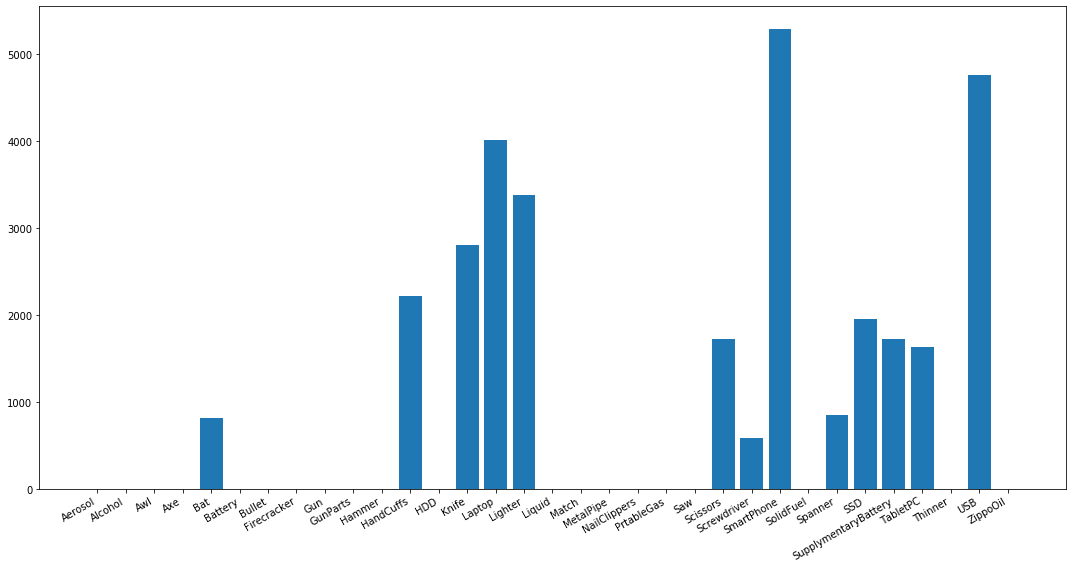

In [267]:
fig, ax = plt.subplots(
    figsize=(15, 8)
)
fig.autofmt_xdate()
plt.bar(label_count_dict.keys(), label_count_dict.values())

plt.tight_layout()
plt.show()

#### Dataloader Data

In [30]:
label_set = list(set(label))
new_label_count_dict = {label: 0 for label in label_set}

for label_value in label:
    new_label_count_dict[label_value] += 1

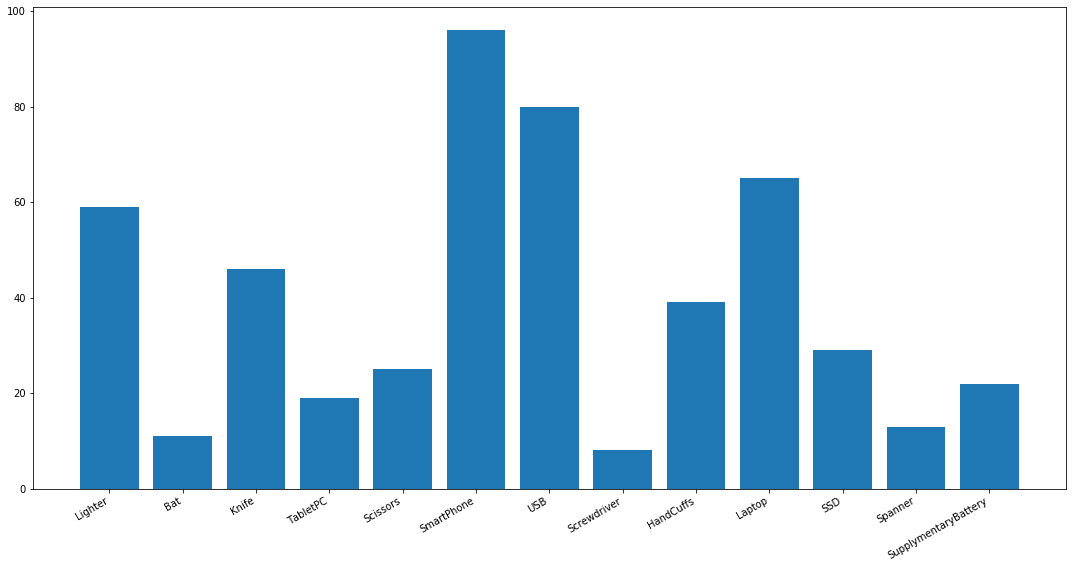

In [31]:
fig, ax = plt.subplots(
    figsize=(15, 8)
)
fig.autofmt_xdate()
plt.bar(new_label_count_dict.keys(), new_label_count_dict.values())

plt.tight_layout()
plt.show()

In [36]:
idx_range = [1, 203, 503, 205, 236]
img_list = list()
label_list = list()

In [37]:
for data_element in data[idx_range]:
    img_3d = data_element.reshape((3, 256, 256))
    img_3d = img_3d.transpose(1, 2, 0)

    img_list.append(img_3d)

In [38]:
for label_element in label[idx_range]:
    label_list.append(label_element)
    print(label_element)

USB
USB
SmartPhone
Lighter
Laptop


USB


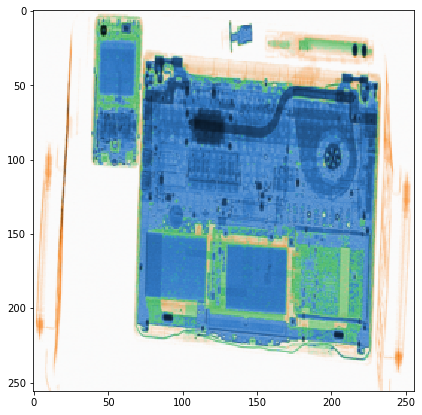

In [39]:
idx = 0

print(label_list[idx])
plt.figure(figsize=(15, 7))
plt.imshow(img_list[idx])
plt.show()

USB


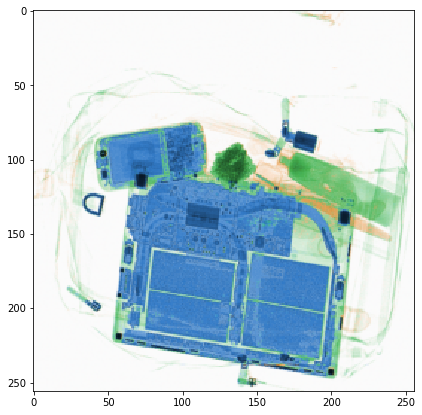

In [40]:
idx = 1

print(label_list[idx])
plt.figure(figsize=(15, 7))
plt.imshow(img_list[idx])
plt.show()

SmartPhone


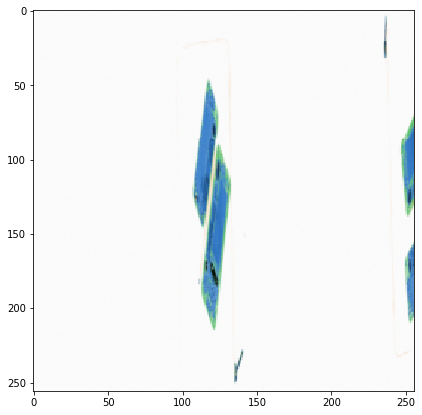

In [41]:
idx = 2

print(label_list[idx])
plt.figure(figsize=(15, 7))
plt.imshow(img_list[idx])
plt.show()

Lighter


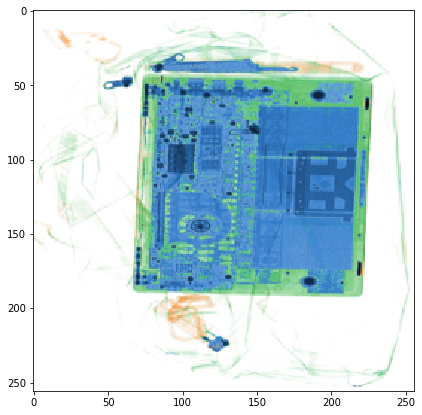

In [42]:
idx = 3

print(label_list[idx])
plt.figure(figsize=(15, 7))
plt.imshow(img_list[idx])
plt.show()

Laptop


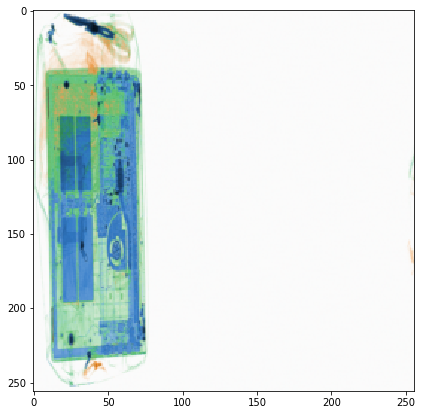

In [43]:
idx = 4

print(label_list[idx])
plt.figure(figsize=(15, 7))
plt.imshow(img_list[idx])
plt.show()

In [26]:
ast_image_path_list, ast_label_list, ast_category_dict, ast_image_metadata_list, ast_avg_img_size = get_path("./datasets/Annotation/Astrophysics.json")

In [27]:
rap_image_path_list, rap_label_list, rap_category_dict, rap_image_metadata_list, rap_avg_img_size = get_path("./datasets/Annotation/Rapiscan.json")

In [28]:
smi_image_path_list, smi_label_list, smi_category_dict, smi_image_metadata_list, smi_avg_img_size = get_path("./datasets/Annotation/Smith.json")

In [14]:
new_ast_image_path_list = list(map(lambda image_path: "." + image_path, ast_image_path_list))
new_rap_image_path_list = list(map(lambda image_path: "." + image_path, rap_image_path_list))
new_smi_image_path_list = list(map(lambda image_path: "." + image_path, smi_image_path_list))

In [30]:
print(len(new_ast_image_path_list), len(new_rap_image_path_list), len(new_smi_image_path_list))

31754 32267 27996


In [16]:
ast_danger_data = DangerDataset(new_ast_image_path_list, ast_label_list, img_size=(256, 256))
rap_danger_data = DangerDataset(new_rap_image_path_list, rap_label_list, img_size=(256, 256))
smi_danger_data = DangerDataset(new_smi_image_path_list, smi_label_list, img_size=(256, 256))

In [29]:
print(ast_avg_img_size, rap_avg_img_size, smi_avg_img_size)

(1920.0, 1080.0) (1680.0090155783892, 1050.0106065628108) (1680.0, 1050.0)


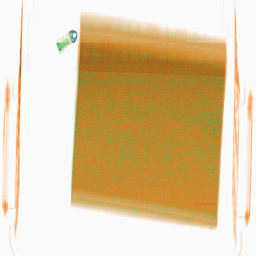

In [17]:
ast_danger_data[0][0]

In [20]:
ast_danger_data[0][1]

'USB'

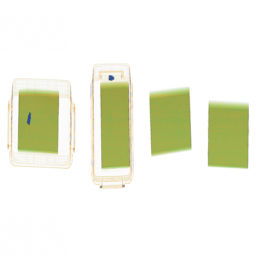

In [18]:
rap_danger_data[0][0]

In [21]:
rap_danger_data[0][1]

'USB'

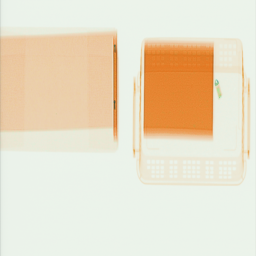

In [19]:
smi_danger_data[0][0]

In [22]:
smi_danger_data[0][1]

'USB'